In [26]:
# Démarrage du thème 3
import visualID as vID
from visualID import color
vID.init()

**Début à:** Wednesday 22 June 2022, 10:45:45  
**Hostname:** 2a02-8440-3341-5fe1-41f9-3b1d-c51e-aab3.rev.sfr.net (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoBegin.svg" style="margin-left:auto; margin-right:auto"/></p>

# Traitement statistique de données<br>(data science pour débutants)
## 3. Apprentissage supervisé (*supervised Machine Learning*) appliqué à la classification<br>(régression logistique)

<div class="warn">
    <b style='color:red'>Ce thème n'est pas si complexe, mais l'analyse du code est réservée aux plus curieu(ses)(x) et motivé(e)s.</b>
    <br>Il a pour objectif de montrer qu'il est possible de prédire une valeur sur la base d'une corrélation multifactorielle entre une <b>classe d'objets</b> (ici des espèces d'iris) et des <b>propriétés</b> (ou descripteurs, ici les largeurs et longueurs des pétales et des sépales) 
    <br><b style='color:red'>Les moins curieu(ses)(x) doivent <i>a minima</i> lire les commentaires et exécuter ce code pour en comprendre le principe.</b>
   </div>

### 3.1. Introduction

#### 3.1.a. Objectif et principe général
On a vu dans la partie précédente (statistiques et régression) qu'il est possible de prédire une valeur ($\hat{y}$) sur la base d'une régression, c'est-à-dire du *fit* d'une équation mathématique qui relie deux variables entre elles ($y$ et $x$). On a pour cela utilisé les outils de régression offerts par la librairie `SciPy`. On a pu ainsi prédire la longueur d'un pétale d'iris, connaissant sa largeur, compte tenu de la relation linéaire entre longueur et largeur.

On a également constaté dans la première partie que la distribution jointe des caractéristiques longueurs et largeurs des pétales (`jointplot`) est presque suffisante pour classifier les 3 espèce d'iris (figure de gauche). La zone de recouvrement entre caractéristiques de pétales des espèces <i>versicolor</i> et <i>virginica</i> ne permet malheureusement pas de trancher entre grands iris <i>versicolor</i> et petits iris <i>virginica</i>. On voit sur la figure de droite que les sépales des iris <i>setosa</i> ont des dimensions différentes des deux autres, alors que <i>versicolor</i> et <i>virginica</i> ont pour la plupart des sépales de dimensions similaires.
<p style="text-align: center"><img width="900px" src="./svg/jointplot_petals-sepals_classification.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></img></p>

<div class="warn">
Le premier objectif de ce TP est d'entraîner un modèle d'Intelligence Artificielle (IA) à <span style="color:red"><b>classifier</b></span> les espèces d'iris sur la base des <span style="color:red">longueurs (L<sub>P</sub>) et largeurs (&ell;<sub>P</sub>) de leurs pétales</span>. L'architecture est la suivante :

<p><img width="350px" src="./svg/IA-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_jpc"/></p>  
    
C'est-à-dire qu'on va spécifier 2 paramètres en entrée, et qu'on veut obtenir en sortie les probabilités <i>P</i> que l'espèce d'iris caractérisée par ces deux propriétés soit de la famille <i>setosa</i>, <i>versicolor</i> ou <i>virginica</i>.
</div>
<br>
<div class="rq">
Il faut d'abord entraîner un modèle à faire un lien entre les 2 caractéristiques de pétales d'une part et espèce d'iris d'autre part. On parle d'<b>apprentissage supervisé</b> (<b><i>supervised machine learning</b></i>). Il existe plusieurs modèles statistiques qui peuvent faire ce type d'apprentissage visant à classifier des individus : arbres de décision, séparateurs à vaste marge (<i>support-vector machine</i>, SVM), réseaux de neurones artificiels (<i>artificial neural network</i>, ANN)... Même si ce n'est pas le plus approprié pour un problème aussi simple que celui-ci, on va utiliser une méthode d'apprentissage profond (<i>deep learning</i>), qui est un réseau de neurones particulier. On va découvrir que mettre au point un modèle de ce type n'est en réalité pas si compliqué que ça.

Voici à quoi ressemble dans ce cas précis une boîte noire exploitant le deep learning : 

<p style="text-align: center"><img width="250px" src="./svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"/></p>

Elle est constituée de neurones artificiels tous connectés entre eux : (a) deux neurones d'entrée qui vont recevoir pour chaque espèce les largeurs et longueurs des pétales; (b) trois neurones de sortie qui vont contenir la probabilité pour que l'iris de cette taille soit <i>setosa</i> (P<sub>1</sub>), <i>versicolor</i> (P<sub>1</sub>) ou <i>virginica</i> (P<sub>3</sub>); (c) deux couches intermédiaires de neurones. Ces couches intermédiaires sont appelées couches cachées. On parle de <b>deep learning</b> pour tout ANN qui contient un mlinimum de deux couches cachées.

Un <b>neurone artificiel</b> est en général caractérisé par
<li> les <b>poids</b> des connexions qui le relie aux autres neurones, c'est-à-dire l'équivalent des poids synaptiques
<li> son "mode de fonctionnement", on parle de <b>fonction d'activation</b>
<li> une constante (le <b>biais</b>) qui aide le modèle (l'IA) à s’adapter au mieux aux données du problème
</div>

#### 3.1.b. Importation des librairies utiles

Outre pandas, les deux librairies majeures sont `TensorFlow` et `Keras`. On utilisera également un peu plus tard des utilitaires fournis par la librairie `scikit learn`.

<p style="text-align: center"><img width="300px" src="./svg/logos-TFKSKL.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_logos"/></p>

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

### 3.2. Préparation des données

#### 3.2.a. Lecture de la base de données qui ont été adaptées au problème
Les données brutes sont en général mal adaptées aux algorithmes d'apprentissage automatique. La/le *data scientist* doit faire en amont un travail de transformation de ces données. On a ici appliqué au préalable un "encodage 1 parmi n" (ou *one-hot-encoding*) des espèces d'iris (les plus curieu(x)(ses) peuvent se référer à l'annexe). On va lire la nouvelle base de données (nommée iris_ohe.csv) afin de plus facilement comprendre en quoi consiste cet encodage.

In [28]:
dfi=pd.read_csv('./iris-data/iris_ohe.csv', sep="\t") #les colonnes sont séparées par des tabulations
print(f"Dfi. Structure (shape) :{dfi.shape}")
display(dfi)

Dfi. Structure (shape) :(150, 8)


,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,setosa,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,setosa,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,setosa,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,setosa,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,virginica,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,virginica,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,virginica,0.0,0.0,1.0


Le nouveau ficher de données contient 3 nouvelles colonnes (*setosa*, *versicolor*, *virginica*), qui ne contient que des 0 ou des 1, qui ne sont rien d'autre que les probabilités que chacune des fleurs d'iris soit setosa, versicolor ou virginica. Comme c'est un botaniste qui a établi de façon sûre la classification de cette base de données, les probabilités ne peuvent valoir que 0 ou 1 (et bien entendu il ne peut y avoir qu'une seule valeur '1.0' par ligne). 

#### 3.2.b. Séparation des données en deux sous-ensembles d'apprentissage et de test
<div class="rq">  
On est au c&oelig;ur de l'apprentissage automatique :
    <li> les algorithmes doivent être entraînés sur la base d'exemples connus et complètement caractérisés
    <li> pour entraîner un algorithme, on va lui donner une multitude d'exemples et, en fonction de la différence entre le résultat obtenu et le résultat attendu, le système va mettre à jour ses "coefficients" : c'est la phase d'apprentissage. Cette optimisation des coefficients se fait en minimisant l'écart entre propriété prédite et propriété réelle (la propriété dans ce cas étant l'espèce d'iris)
    <li> dans le cas d'un réseau de neurones, les coefficients sont les <b>poids des connexions neuronales</b>, ainsi qu'un paramètre caractéristique de chaque neurone (appelé le <b>biais</b>)
    <li> comme pour tout apprentissage, il faut vérifier que les acquis sont solides, c'est la phase de test. Une fois l'algorithme entraîné, on va lui soumettre de nouveaux exemples connus et évaluer sa capacité à donner la bonne réponse.
 <br><br>   
Tout jeu de données est séparé en deux sous-ensembles :
    <li> un jeu de données d'<b>apprentissage</b>
    <li> un jeu de données de <b>test</b>, indépendantes du jeu de données d'apprentissage, mais qui suit la même distribution de probabilité

(C'est ici une approche simplifiée. Dans une approche plus rigoureuse, on sépare la base de données en trois jeux : apprentissage, validation, test).
              
Le principe est résumé dans la figure ci-dessous :
        
<p style="text-align: center"><img width="750px" src="./svg/holdout.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_holdout"/> </p>
</div>

In [29]:
# création d'un jeu de données sous forme de dataFrame (data_train) qui contient 80% des échantillons, sélectionnés de façon aléatoire
# ce sont les données qui vont servir à l'entraînement de l'algorithme
data_train = dfi.sample(frac=0.8, axis='index') 
# création d'un nouveau dataFrame (data_test) qui contient les 20% restants
# ce sont les données qui vont servir à tester l'algorithme sur des données qui lui sont inconnues
data_test  = dfi.drop(data_train.index)

# sélection des données d'apprentissage (d'entraînement)
# x_train contient l'input, c'est-à-dire la largeur et la longueur de chacun des pétales du jeu de données data_train 
x_train = data_train[['petal_length','petal_width']]
# y_train contient ce qu'on veut faire apprendre à l'algorithme, c'est-à-dire le type de chacun  des iris du jeu de données data_train. 
# comme on veut que l'algorithme prédise des probabilités, on va lui faire apprendre ce type d'information
y_train = data_train[['setosa','versicolor','virginica']]
y_train_species = data_train[['species']] #sera utile à la fin pour comparer la prédiction et l'espèce réelle

# sélection des données de test
# on fait pareil que précédemment, mais pour tester l'algorithme (l'IA) une fois qu'il sera optimisé
x_test  = data_test[['petal_length','petal_width']]
y_test  = data_test[['setosa','versicolor','virginica']]
y_test_species = data_test[['species']]


# Affichage pour mieux comprendre ce qu'on vient de créer
print('x_train : ',x_train.shape)
display(x_train)
print('y_train : ',y_train.shape,'y_train_species : ',y_train_species.shape)
display(y_train, y_train_species)

x_train :  (120, 2)


,petal_length,petal_width
108,5.8,1.8
143,5.9,2.3
88,4.1,1.3
35,1.2,0.2
100,6.0,2.5
...,...,...
92,4.0,1.2
14,1.2,0.2
103,5.6,1.8
10,1.5,0.2


y_train :  (120, 3) y_train_species :  (120, 1)


,setosa,versicolor,virginica
108,0.0,0.0,1.0
143,0.0,0.0,1.0
88,0.0,1.0,0.0
35,1.0,0.0,0.0
100,0.0,0.0,1.0
...,...,...,...
92,0.0,1.0,0.0
14,1.0,0.0,0.0
103,0.0,0.0,1.0
10,1.0,0.0,0.0


,species
108,virginica
143,virginica
88,versicolor
35,setosa
100,virginica
...,...
92,versicolor
14,setosa
103,virginica
10,setosa


#### 3.2.c. Adaptation des données à la régression logistique par le réseau de neurones
Regardons d'abord quelle sont la longueur et largeur moyennes des pétales. On va pour cela utiliser la fonction  `describe()` de `pandas` :

In [30]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set avant normalisation"))

,petal_length,petal_width
count,120.00,120.00
mean,3.78,1.20
std,1.75,0.76
min,1.00,0.10
25%,1.60,0.30
50%,4.30,1.30
75%,5.10,1.80
max,6.90,2.50


En moyenne, les pétales sont trois plus longs que larges. Le risque encouru lors de l'apprentissage est que l'algorithme considère que la longueur est une caractéristique plus importante que la largeur. Il est d'usage d'appliquer une procédure de standardisation afin d'éviter cet écueil. C'est l'objet des quelques lignes ci-dessous, qui exploitent les outils de normalisation des caractéristiques fournis par la libraririe `scikit learn`. 
<div class="warn"><b>Attention ! </b>Toute donnée soumise à l'algorithme doit au préalable être standardisée à l'aide de la commande <code>scaler.transform()</code> de la librairie <code>scikit learn</code></div>

In [31]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
x_trainS = scaler.transform(x_train.values) #returns a numpy array
x_testS = scaler.transform(x_test.values) #returns a numpy array
#conversion into a dataframe just for display and plotting purpose
x_trainDF = pd.DataFrame(x_trainS, columns=x_train.columns, index=x_train.index)
x_testDF = pd.DataFrame(x_testS, columns=x_test.columns, index=x_test.index)
#
x_train = x_trainS
x_test = x_testS

In [32]:
display(x_trainDF.describe().style.format("{0:.2f}").set_caption("Training set après standardisation"))

,petal_length,petal_width
count,120.00,120.00
mean,-0.00,-0.00
std,1.00,1.00
min,-1.59,-1.46
25%,-1.25,-1.20
50%,0.30,0.13
75%,0.76,0.79
max,1.79,1.72


<div class="warn">
La distribution renormalisée des longueurs et largeurs du training set vient d'être affichée. Analysez ces résultats et comparez-les à ceux calculés avant la standardisation.
<br><b>NB.</b> Le test set a lui aussi été standardisé.
</div>

### 3.3. Modèle de réseau de neurones (ANN = artificial neural network)
On va maintenant
- définir un modèle de réseau de neurones
- lancer son apprentissage (dit supervisé, car l'algorithme doit à apprendre à prédire à partir d'exemples annotés)


#### 3.3.a. Définition du modèle
<div class="rq">
    
On va définir le réseau de neurones. Rappelons d'abord l'architecture du réseau quon va évaluer ici :
    <p style="text-align: center"><img width="250px" src="./svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"/></p>

Grâce à la simplicité de `Keras`, chaque couche de neurones est définie par une *unique* ligne. 
- la première définit la couche d'entrée. Le nombre de neurones (*NE*) est passé en paramètres du modèle
- la 2ème et la 3ème sont les couches cachées, définies par le nombre de neurones qui les constituent et par leur mode d'activation
- la 4ème ligne est la couche de sortie, définie par 3 neurones et par lafonction d'activation. Cette fonction `softmax` est adaptée à la classification

Puis on indique à `Keras` de configurer le modèle (`compile`) :
- L'optimiseur est la méthode de minimisation entre ce qu'on veut faire apprendre et ce que l'algorithme restitue pendant son apprentissage
- On va minimiser l'écart entre probabilités connues (les 3 $y_k$) et probabilités prédites ($\hat{y}_k$) . C'est la fonction `loss`. Pour une classification, il est recommandé d'utiliser la fonction `categorical cross entropy`, qui est un peu plus complexe en réalité que $y_k-\hat{y}_k$, puisque son expression est(\*) :
$$-\frac{1}{n}\sum_{k}\left(y_{k}\log\hat{y}_{k}(\boldsymbol{\theta})+(1-y_{k})\log(1-\hat{y}_{k}(\boldsymbol{\theta}))\right)^{2}$$
- on demande également au modèle de renvoyer la précision (`accuracy`) grâce à la variable `metrics`. Ça va permettre d'évaluer la capacité prédictive du modèle, puisque c'est basé sur le nombre d'identifications correctes et erronées (les vrais ou faux positifs ou négatifs)

(\*) le paramètre $\boldsymbol{\theta}$ représente l'ensemble des poids des connexions neuronales ainsi que l'ensemble des biais associé à chaque neurone 
</div>

In [33]:
def define_model(NE): #NE = nombre de neurones d'entrée
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(NE, name='iLayer'))
    model.add(keras.layers.Dense(7, activation='relu', name='hLayer1'))
    model.add(keras.layers.Dense(5, activation='relu', name='hLayer2'))
    model.add(keras.layers.Dense(3, activation='softmax', name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'categorical_crossentropy',
                  metrics   = ['accuracy'] )
    return model

#### 3.3.b. Apprentissage supervisé du réseau de neurones
C'est maitenant qu'on lance l'apprentissage.
- on définit d'abord le modèle `ANNmodel=define_model( (2,)) `, où 2 = 2 neurones d'entrée (largeur et longueur)
- on lance son optimisation `ANNmodel.fit`. L'algorithme (l'IA) optimal ainsi que les algorithmes intermédiaires vont être sauvegardés en tant que `ANNhistory`

<div class="warn"><b>Qu'est-ce qui est sauvé au juste ?</b>
Les poids des connexions et les biais, dont l'optimisation a conduit à améliorer la reconnaissance des iris
</div>

Les principaux paramètres de `ANNmodelfit` sont
- les caractéristiques d'entrée : `x_train`
- les classes qu'on veut prédire en fonction des caractéristiques d'entrée : `y_train`
- le nombre maximal de cycle d'apprentissage (`epochs`)
- les jeux de données qui vont permettre à chaque pas d'apprentissage (d'optimisation) d'évaluer les performances de l'algorithme sur des données qui ne servent pas à l'apprentisssage (sorte de "contrôle continu intégral et permanent") : `x_test` et le résultat attendu, `y_test`

In [34]:
vID.chrono_start()
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
ANNmodel=define_model( (2,)) # 2 neurones d'entrée
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 700,
                    batch_size      = 5,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hLayer1 (Dense)              (None, 7)                 21        
_________________________________________________________________
hLayer2 (Dense)              (None, 5)                 40        
_________________________________________________________________
oLayer (Dense)               (None, 3)                 18        
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Epoch 1/700
24/24 [==============================] - 1s 17ms/step - loss: 1.1578 - accuracy: 0.0337 - val_loss: 1.1094 - val_accuracy: 0.0333
Epoch 2/700
24/24 [==============================] - 0s 5ms/step - loss: 1.1168 - accuracy: 0.0181 - val_loss: 1.0622 - val_accuracy: 0.4000
Epoch 3/700
24/24 [==============================] - 0s 6ms/step - loss: 1.0674 - accuracy: 0.3169 - val_

On va tracer l'évolution de la précision et de la fonction loss au cours des cycles d'apprentissage. On va le faire à la fois pour les données qui ont servi à l'apprentissage (*train*) et pour celles du "contrôle continu" (*test*)

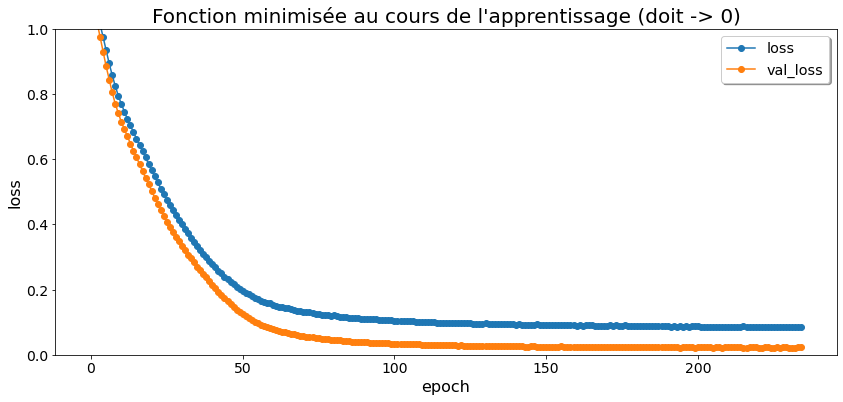

In [35]:
# c'est pratique d'utiliser un dataframe et les fonctions de tracé associées
df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
# on va d'abord tracer les courbes de la fonction qui a été minimisée au cours de l'apprentissage
figLOSS=df.plot(y=["loss","val_loss"],linestyle='-', marker='o',fontsize=14)
figLOSS.set_xlabel('epoch',fontdict={'fontsize':16})
figLOSS.set_ylabel('loss',fontdict={'fontsize':16})
figLOSS.set_ylim([0.0,1.0])
figLOSS.set_title("Fonction minimisée au cours de l'apprentissage (doit -> 0)", size=20)
figLOSS.legend(loc='upper right', shadow=True, fontsize='x-large')


#conversion into a dataframe<div style="warn">
<li> <span style="color:#1a6495">l'algorithme apprend de mieux en mieux à reconnaître les iris au cours des cycles d'apprentissage (courbe "loss")</span>
<li> <span style="color:#c1600b">il est aussi capable de convenablement classer les espèces qu'il ne connaît pas (c'est-à-dire qui n'ont pas été utilisées pour son apprentissage, courbe "val_loss")</span>
</div> 

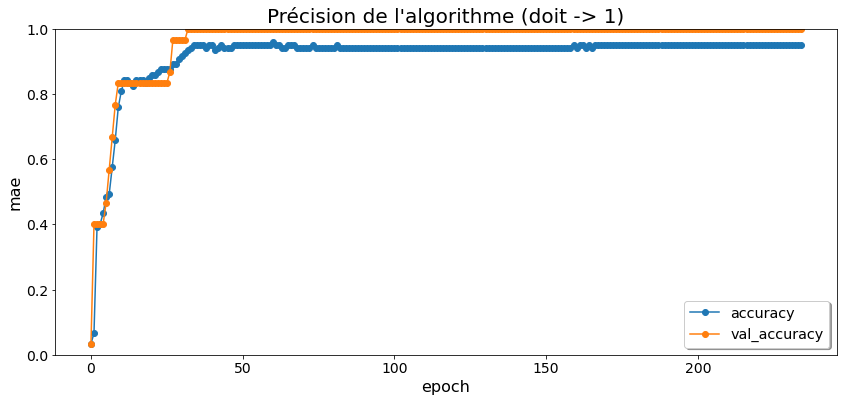

In [36]:
# création d'un nouveau dataFrame qui permet de juger de l'évolution de la précision de l'algortihme
figACC=df.plot(y=["accuracy","val_accuracy"],linestyle='-', marker='o',fontsize=14)
figACC.set_xlabel('epoch',fontdict={'fontsize':16})
figACC.set_ylabel('mae',fontdict={'fontsize':16})
figACC.set_ylim([0.0,1.0])
figACC.set_title("Précision de l'algorithme (doit -> 1)", size=20)
figACC.legend(loc='lower right', shadow=True, fontsize='x-large')

<div style="warn">
<li> <span style="color:#1a6495">on a confirmation que l'algorithme apprend de mieux en mieux à reconnaître les iris au cours des cycles d'apprentissage (courbe "accuracy"). Il ne commet quasiment aucune erreur en fin d'apprentissage puisque ce paramètre tend vers 1.</span>
<li> <span style="color:#c1600b">la courbe "val_accuracy" montre que l'algorithme commet également peu d'erreurs d'identification des espèces qui n'ont pas servi à son apprentissage</span>
</div> 

### 3.4. Évaluation de la précision du réseau de neurones après apprentissage

#### 3.4.a. Évaluation numérique globale
On introduit ici la fonction `evaluate` de `Keras`. On lui fournit un jeu de données d'entrée et le résultat attendu. Elle va se servir du modèle optimisé (car on fait appel à `ANNmodel.evaluate`) afin de renvoyer les valeurs des erreurs "loss" et "accuracy"

In [37]:
evalANN_on_TrainSet = ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {evalANN_on_TrainSet[0]:5.4f}{color.OFF}")
print(f"{color.GREEN}x_train/ accuracy  : {evalANN_on_TrainSet[1]:5.4f}{color.OFF}")
print()
evalANN_on_TestSet = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_train / loss      : {evalANN_on_TestSet[0]:5.4f}{color.OFF}")
print(f"{color.BLUE}x_train/ accuracy  : {evalANN_on_TestSet[1]:5.4f}{color.OFF}")

x_train / loss      : 0.0840
x_train/ accuracy  : 0.9500

x_train / loss      : 0.0225
x_train/ accuracy  : 1.0000


#### 3.4.b. Utilisation de l'algorithme ANN comme prédicteur
On avait posé cet exercice dans la deuxième partie ("statistiques et régression")
<div class="rq"><b>Problème. </b>
Un botaniste a découvert au fond de son jardin un Iris de la famille <i>setosa</i>, dont les pétales sont de largeur 0.25 cm.
<ol>
    <li> quelle est la longueur de pétale peut-on prédire, à partir de la base de données "iris"?
    <li> la longueur mesurée est en fait de 1.45 cm. Quelle est l'erreur quadratique commise par le modèle statistique ?
</ol> 
</div>
<br>
<div class="warn"><b>Peut-on répondre à ces questions à l'aide du réseau de neurones optimisé?</b>
<br>Non. Ce modèle statistique n'est pas conçu pour ça.</div>
<br>
On va en revanche pouvoir répondre à la question suivante:
<div class="rq"><b>Problème. </b>
À l'occasion d'une randonnée, vous venez de découvrir un Iris, dont les pétales sont de dimension moyenne 1.45 cm x 0.25 cm. Vous êtes nul en botanique, mais grâce aux petites applications d'IA "maison" que vous avez sauvées sur votre smartphone, vous allez en déduire de quelle espèce il s'agit.
</div>

On va simplement utiliser la fonction `predict`, qui va renvoyer trois valeurs de probabilité (dans l'ordre setosa, versicolor, virginica) :

In [51]:
# attention : les données sont entrées dans l'ordre longueur puis largeur, sous forme de tableau au format numpy
sample = [0.25, 1.45]
print(f"probabilités: {ANNmodel.predict([sample])}")

probabilités: [[8.3257782e-04 3.5322297e-02 9.6384507e-01]]


<div class="warn">L'algorithme n'a pas de doute sur le fait que c'est un iris de type <i>virginica</i>. <b>Êtes-vous d'accord?</b> (on suggère de se reporter à la figure reliant longueur et largeur, reportée dans l'introduction)<br>
<br>
En fait, on a oublié une étape préliminaire, la <b><span style="color:red">standardisation des données...</span></b>
<br>L'algorithme a été optimisé sur la base de données d'entrées standardisées. Toute nouvelle donnée qui lui est soumise doit elle aussi être standardisée. On va pour cela à nouveau utiliser la commande <code>scaler.transform()</code> de la librairie <code>scikit learn</code>
</div>

In [53]:
sample = [0.25, 1.45]
print(f"échantillon avant la standardisation : {sample}")
print(f"probabilités avant standardisation: {ANNmodel.predict([sample])}")
print()

sample = scaler.transform([sample])
print(f"échantillon après la standardisation : {sample}")
print(f"probabilités après standardisation: {ANNmodel.predict([sample])}")

échantillon avant la standardisation : [0.25, 1.45]
probabilités avant standardisation: [[8.3257782e-04 3.5322297e-02 9.6384507e-01]]

échantillon après la standardisation : [[-2.02375117  0.3284725 ]]
probabilités après standardisation: [[0.9677852  0.03017354 0.00204137]]


<div class="warn">Ça change tout. Et c'est maintenant une prédiction correcte (<i>en principe, sauf si l'algorithme a par malchance mal appris sa leçon. il n'y a aucune assurance avec un si petit jeu de données d'apprentissage</i>).</div>

On va utiliser dans le paragraphe suivant les fonctions `argmax` de `numpy `, ainsi que la fonction `unique` de `pandas`. On va regarder leur comportement ici :

In [54]:
probas = ANNmodel.predict([sample])
print("probas: ", probas)
print("argmax(probas): ",np.argmax(probas)) #va renvoyer l'indice de l'élément qui a la valeur la plus élevée de toute la liste

probas:  [[0.9677852  0.03017354 0.00204137]]
argmax(probas):  0


`unique`, dont on montre l'utilité ci-dessous, a aussi été utilisé pour fabriquer les dernières colonnes de la base de données utilisée dans ce notebook

In [55]:
usp = dfi['species'].unique() # usp = Unique SPecies
print(usp)

['setosa' 'versicolor' 'virginica']


C'est-à-dire que l'élement 0 de usp contient le nom de l'espèce

Donc si on utilise la résultat de `argmax(probas)` en argument de usp, ça va directement renvoyer le nom de l'espèce plutôt qu'une liste de probabilités :

In [56]:
print("l'iris observé est de type :",usp[np.argmax(probas)])

l'iris observé est de type : setosa


#### 3.4.c. Comportement du modèle vis-à-vis de chaque espèce d'iris
La partie ci-dessous est un peu longue, mais pas compliquée. L'objectif est d'afficher les probailités pour chacun des échantillons du jeu d'apprentissage (train). Elles sont converties en espèce grâce à `argmax` et à la liste `usp`. On peut ainsi directement comparer avec les espèces réellement observées. La fin du script permet de comptabiliser les erreurs.

Puis il est fait de même pour les échantillons du jeu de test.

In [57]:
usp = dfi['species'].unique()
print(f"{color.BOLD}{color.GREEN}Catégories uniques d'iris :{color.OFF} {usp}")
# cette correspondance élément 0 <-> setosa ; élément 1 <-> versicolor ; élément 2 <-> virginica
# va servir à transformer les probabilités les plus élevées en espèce d'iris

y_train_hat=ANNmodel.predict(x_train)
ytr_hD = pd.DataFrame(y_train_hat, columns=usp, index=y_train.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tr_hat = usp[np.argmax(y_train_hat,axis=1)]
# on ajoute cette colonne au dataframe ytr_hD
ytr_hD['Espèce prédite'] = pd.DataFrame(iris_tr_hat, index=y_train.index)
ytr_hD['Espèce observée'] = pd.DataFrame(y_train_species, index=y_train.index)
print(f"{color.BOLD}{color.BLUE}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytr_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: format standard 
diff_Pred_Obs=np.where(ytr_hD['Espèce prédite'] == ytr_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

print()
y_test_hat=ANNmodel.predict(x_test)
ytt_hD = pd.DataFrame(y_test_hat, columns=usp, index=y_test.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tt_hat = usp[np.argmax(y_test_hat,axis=1)]
# on ajoute cette colonne au dataframe ytt_hD
ytt_hD['Espèce prédite'] = pd.DataFrame(iris_tt_hat, index=y_test.index)
ytt_hD['Espèce observée'] = pd.DataFrame(y_test_species, index=y_test.index)
print(f"{color.BOLD}{color.RED}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée.")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytt_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: 
diff_Pred_Obs=np.where(ytt_hD['Espèce prédite'] == ytt_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

Catégories uniques d'iris : ['setosa' 'versicolor' 'virginica']
Test Set. Comparaison entre espèce prédite et espèce observée


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
108,0.00,0.00,0.99,virginica,virginica
143,0.00,0.00,1.00,virginica,virginica
88,0.00,1.00,0.00,versicolor,versicolor
35,1.00,0.00,0.00,setosa,setosa
100,0.00,0.00,1.00,virginica,virginica
31,1.00,0.00,0.00,setosa,setosa
62,0.00,1.00,0.00,versicolor,versicolor
20,1.00,0.00,0.00,setosa,setosa
74,0.00,1.00,0.00,versicolor,versicolor
49,1.00,0.00,0.00,setosa,setosa


Nombre d'erreurs : 6

Test Set. Comparaison entre espèce prédite et espèce observée.


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
0,1.00,0.00,0.00,setosa,setosa
3,1.00,0.00,0.00,setosa,setosa
6,1.00,0.00,0.00,setosa,setosa
13,1.00,0.00,0.00,setosa,setosa
16,1.00,0.00,0.00,setosa,setosa
18,1.00,0.00,0.00,setosa,setosa
19,1.00,0.00,0.00,setosa,setosa
24,1.00,0.00,0.00,setosa,setosa
26,1.00,0.00,0.00,setosa,setosa
32,1.00,0.00,0.00,setosa,setosa


Nombre d'erreurs : 0


<div class="warn">Ce serait assez fastidieux à analyser si la base de données était constituée de milliers d'échantillons. La libraririe <code>scikit learn</code> permet de visualiser de façon graphique les succcès et erreurs d'un algorithme. Il s'agit de <b style="color:red">matrices de confusion</b>. C'est l'objet du paragraphe suivant.</div>

#### 3.4.d. Bilan de la performance du modèle prédictif sous forme de matrice de confusion

Training set. Matrice de confusion


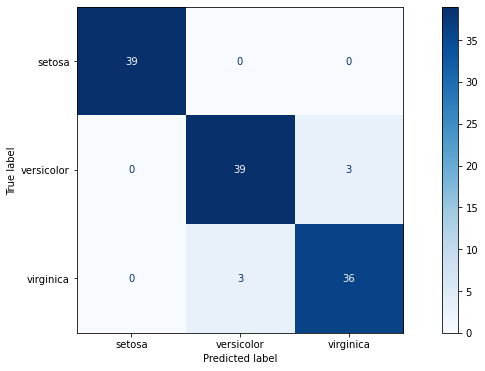

Test set. Matrice de confusion


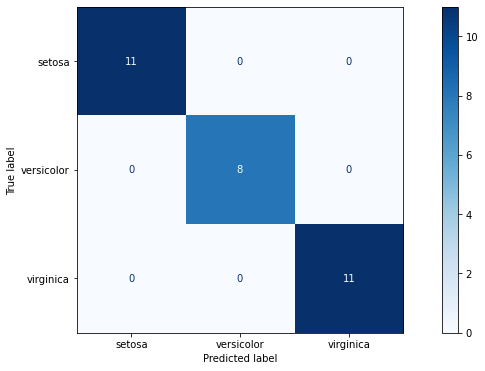

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm_labels = dfi['species'].unique()
print("Training set. Matrice de confusion")
cm_tr = confusion_matrix(np.argmax(y_train.to_numpy(),axis=1), np.argmax(y_train_hat,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=cm_labels)
disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
plt.show()
print("Test set. Matrice de confusion")
cm_tt = confusion_matrix(np.argmax(y_test.to_numpy(),axis=1), np.argmax(y_test_hat,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tt, display_labels=cm_labels)
disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
plt.show()

<div class="warn">
On rappelle à quoi ressemble la corrélation entre longueurs et largeurs de pétales, et l'apparente classification par espèce qui nous a amenés à bâtir une IA d'identification à partir de ces caractéristiques de dimension de pétales:
    <p style="text-align: center"><img width="500px" src="./svg/jointplot_petals.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
<li> il n'est pas surprenant que l'algorithme ne se trompe jamais dans l'identification des iris <i>setosa</i>, qui sont nettement plus petits que les autres
<li> les seules erreurs sont une confusion entre <i>versicolor</i> et <i>virginica</i>
<li> si on prend le temps de remonter aux échantillons concernés, on s'aperçoit que les erreurs sont le plus ouvent commises pour des espèces dont les dimension de pétales sont environ 5 x 1.9 cm, c'est-à-dire dans la zone de recouvrement entre les deux espèces dans la figure ci-dessus. <b> Il n'y a donc pas de miracle, sur la base des données qu'on lui a fournies, l'IA ne peut pas faire mieux que nous.</b>
</div>

### Bilan de la troisième partie
<div class='rq'>

La figure ci-dessous résume comment est en général développé et optimisé un algorithme d'apprentissage automatique. C'est ce "workflow" que nous venons d'appliquer.  
<p style="text-align: center"><img width="750px" src="./svg/BilanML-Classification.svg" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>
 
On a développé ici un algorithme de reconnaissance basé sur deux caractéristiques, les longueur et largeur des pétales d'iris. C'est un assez gros effort algorithmique alors qu'il suffit finalement d'exploiter le graphique reliant longueur et largeur, avec le code couleur qui permet de classer les espèces en fonction de cela. En résumé, les petits iris sont des setosa, les grands sont des virginica et les moyens sont des versicolor. <b>Dit comme ça, ça semble facile, mais ce sont des compétences (mesure, tracé de graphique, exploitation d'un graphique) qu'on a nous-mêmes dévelopé quelque part entre fin de l'école élémentaire et le collège</b>. <span style="color:red">On a donc pour le moment une IA niveau "*entrée en sixième*".</span> 

L'exercice qui est proposé en complément vise à développer un algorithme capable d'établir une corrélation plus complexe, en prenant simultanément en compte les longueurs et largeurs des pétales et des sépales. Et ça permet effectivement de diminuer l'erreur commise. On conviendra que ça devient plus compliqué pour nos cerveaux de rechercher si les corrélations croisées, reportées dans la figure ci-dessous, permettent une meilleure classification. C'est pour ce type de tâche, au-delà de corrélations simples, que l'utilisation de ces algorithmes prend tout son sens. 
<p style="text-align: center"><img width="850px" src="./svg/pairplot_Iris.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></p>

</div>

In [60]:
vID.end()

**Fin à:** Wednesday 22 June 2022, 11:08:08  
**Durée:** 00:22:23 935ms

<p style="text-align: center"><img width="800px" src="./svg/logoFin.svg" style="margin-left:auto; margin-right:auto"/></p>